# NLP - Classification and Sentiment Analysis of Reddit Posts

## Part 2: Exploratory Data Analysis

Part 1: Web API Data Collection <br>
Part 2: Exploratory Data Analysis <br>
Part 3: Baseline Classification Models and Zero Shot Classification <br>
Part 4: PyCaret Classification Models <br>
Part 5: Sentiment Analysis <br>

---

In part 2, exploratory data analysis were done to understand contents of text from 'Google' and 'Apple' subreddits. Text data were cleaned for downstream analysis and modelling.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# For text processing
import re
import emoji
import contractions
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Switch off warning
import warnings
warnings.filterwarnings("ignore")

## Import Data

In [12]:
apple = pd.read_csv('Scraped Datasets/apple_posts',usecols=['subreddit', 'selftext', 'title'])
print(apple.shape)
apple.head()

(19963, 3)


,selftext,subreddit,title
0,[removed],apple,iPhone XS Screen Yellow tints
1,[removed],apple,Dynamic Island Questions
2,[removed],apple,What are the advantages of using Apple TV agai...
3,NaN,apple,Gates
4,[removed],apple,Why is the 'This song is not currently availab...


In [13]:
google = pd.read_csv('Scraped Datasets/google_posts',usecols=['subreddit', 'selftext', 'title'])
print(google.shape)
google.head()

(19973, 3)


,selftext,subreddit,title
0,[removed],google,Frauenärztin München Zentrum - Schwangerenvors...
1,"I don't have high expectations, I am not delus...",google,Petition to save Stadia
2,NaN,google,Google Stadia will be shutting down in January...
3,NaN,google,Google won't let you create an email without a...
4,[removed],google,Recover Android backup with different resoluti...


## Missing Values

Some of the reddit posts appear to have no contents.
- [removed] means posts were deleted by moderators
- [deleted] means posts were deleted by authors

If there are still text in the title, these observations will be preserved. If there are no text data related to the post at all, the observation will be dropped from further analysis.

In [14]:
# Replace [removed]/[deleted] with null values
apple['selftext'] = apple['selftext'].replace(['[removed]','[deleted]'],np.nan)
google['selftext'] = google['selftext'].replace(['[removed]','[deleted]'],np.nan)

In [15]:
# Remove empty posts (posts without any text in the title)
google = google.dropna(axis=0,subset='title')
print(google.shape)

(19971, 3)


In [16]:
# Misisng values in google subreddit
google.isnull().sum()/len(google)

selftext     0.881979
subreddit    0.000000
title        0.000000
dtype: float64

In [17]:
# Misisng values in apple subreddit
apple.isnull().sum()/len(google)

selftext     0.97932
subreddit    0.00000
title        0.00000
dtype: float64

- Majority of the posts only has a title but no self-text (body of content in the post)
- Hence, title and self-text will be combined for subsequent text analysis

## Combine Text

In [18]:
# Function to combine title and selftext into a new column - text
def combine_text(row):
    if type(row['selftext']) == str:
        row['text'] = row['title']+' '+row['selftext']
    else:
        row['text'] = row['title']
    return row['text']

In [19]:
# Combine text data in 'Apple' subreddit
tqdm.pandas()
apple['text'] = apple.progress_apply(combine_text,axis=1)

100%|███████████████████████████████████| 19963/19963 [00:14<00:00, 1420.72it/s]


In [20]:
# Combine text data in 'Google' subreddit
google['text'] = google.progress_apply(combine_text,axis=1)

100%|███████████████████████████████████| 19971/19971 [00:14<00:00, 1419.39it/s]


In [21]:
google_text = google[['text','subreddit']]
apple_text = apple[['text','subreddit']]

## Duplicated Posts

Quick scan of duplicated posts in the subreddits. These duplicated posts will be removed subsequently.

In [22]:
# Duplicated posts in 'Google' subreddit
google_text['text'].value_counts().sort_values(ascending=False).head(5)

Google Email Signature                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     37
Buy Verified PayPal Accounts - Personal &amp; Business Accounts                                                                                                                                                                                                                                                           

- Notice that spam advertisement was among the most repeated post

In [23]:
# Duplicated posts in 'Apple' subreddit
apple_text['text'].value_counts().sort_values(ascending=False).head(5)

Help                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      27
Question                                                                                                                                                                                   

In [24]:
# Find spam advertisements with the keyword 'Buy'
google_text.loc[google_text['text'].str.contains('Buy'),'text'].value_counts().sort_values(ascending=False).head(5)

Buy Verified PayPal Accounts - Personal &amp; Business Accounts    37
Buy Google Reviews - Buy 5 Star Google reviews                     22
Buy Google 5 Star Reviews - 100% Secure &amp; Non Drop Rating      21
Buy Negative Google Reviews - BuyUSmarket                          11
Buy Google Reviews                                                 10
Name: text, dtype: int64

In [25]:
# Remove spam advertisements
google_text = google_text[google_text['text'].str.contains('Buy')==False]
print(google_text.shape)

(19502, 2)


## Text Cleaning

The following text cleaning steps will be taken:
- Remove hyperlinks
- Remove 'r/', which is commonly used in reddit to refer to other subreddits
- Remove "&amp", which represents text ampersand in HTML
- Expand contraction (e.g. convert "won't" to "will not") so that meaning of words can be preserved after removing special characters
- Remove special characters and digits
- Convert to lower cases
- Remove duplicated texts

In [26]:
def clean_text(df):
    
    # Number of rows before cleaning
    row_before = len(df)
    
    # Remove hyperlinks
    df['text'] = df['text'].apply(lambda x:re.sub(r'http\S+', '', x))
    
    # Remove r/
    df['text'] = df['text'].replace('r/','')
    
    # Remove &amp;
    df['text'] = df['text'].replace('&amp;','')
    
    # Expand Contraction 
    df['text'] = pd.Series([contractions.fix(row) for row in df['text']])
    
    # Remove special characters and digits (including emojis)
    df['text'] = df['text'].apply(lambda x:re.sub(r'[^a-zA-Z\s]', '', str(x)).strip())
    
    # Convert to lower case
    df['text'] = df['text'].apply(str.lower)
    
    # Remove duplicated texts
    df.drop_duplicates(subset='text',inplace=True)
    
    # Number of rows after cleaning
    row_after = len(df)
    
    print(f'{row_before-row_after} rows removed.')
    print(f'Final dataframe shape: {df.shape}')

In [27]:
clean_text(google_text)

2421 rows removed.
Final dataframe shape: (17081, 2)


In [28]:
clean_text(apple_text)

987 rows removed.
Final dataframe shape: (18976, 2)


## Feature Engineering

Two new features were created:
- Length of post (number of characters)
- Word counts

In [29]:
def create_features(df):
    # Length of texts (number of characters)
    df['length_of_text'] = df['text'].apply(len)
    
    # Word counts
    df['word_count'] = [len(re.findall(r'\w+',row)) for row in df['text']]
    return df

In [30]:
create_features(google_text)
create_features(apple_text)

,text,subreddit,length_of_text,word_count
0,iphone xs screen yellow tints,apple,29,5
1,dynamic island questions,apple,24,3
2,what are the advantages of using apple tv agai...,apple,97,19
3,gates,apple,5,1
4,why is the this song is not currently availabl...,apple,127,26
...,...,...,...,...
19958,tsmc clarifies apples ultrafusion chiptochip i...,apple,57,6
19959,what is the point of getting a high device sto...,apple,90,18
19960,what was your first apple product,apple,33,6
19961,here is a realworld look at how the iphone li...,apple,73,14


## Exploratory Visualisation

- Distribution of length of text
- Distribution of word counts
- Frequent words

#### Distribution of Length of Text

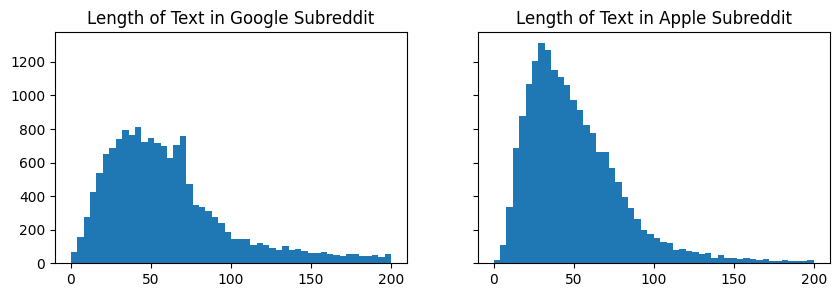

In [31]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True,figsize = (10,3))
axes[0].hist(x=google_text['length_of_text'],bins=50,range=(0,200))
axes[0].set_title('Length of Text in Google Subreddit', fontsize=12)

axes[1].hist(x=apple_text['length_of_text'],bins=50,range=(0,200))
axes[1].set_title('Length of Text in Apple Subreddit', fontsize=12);

- Distribution appears similar, most users in both subreddits tend to write short posts within 50 characters.

#### Distribution of Word Counts

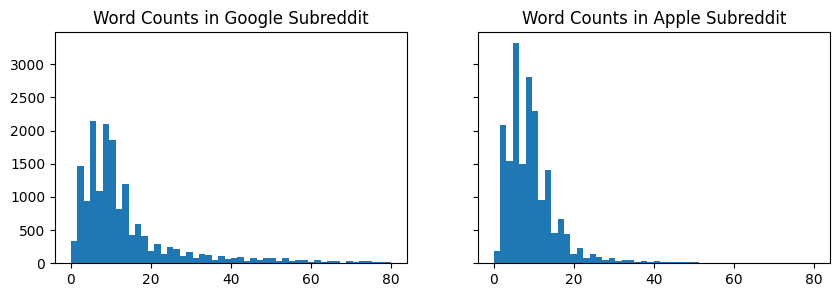

In [32]:
fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True,figsize = (10,3))
axes[0].hist(x=google_text['word_count'],bins=50,range=(0,80))
axes[0].set_title('Word Counts in Google Subreddit', fontsize=12)

axes[1].hist(x=apple_text['word_count'],bins=50,range=(0,80))
axes[1].set_title('Word Counts in Apple Subreddit', fontsize=12);

- Distribution appears similar, most users in both subreddits tend to write short posts with less than 20 words.

#### Frequent Words

**Unigram**

In [33]:
# Function to plot most frequent words after vectorizing
def word_count(df,col='text',ngram_range=(1,1)):
    
    # Vectorize the text using CountVectorizer
    vec = CountVectorizer(stop_words='english',ngram_range=ngram_range)
    df_vec = vec.fit_transform(df[col])
    df_vec = pd.DataFrame(df_vec.toarray(),columns=vec.get_feature_names_out())
    
    # Plot top 10 most frequent words
    plt.figure(figsize = (5,3))
    plot = df_vec.sum().sort_values(ascending=False).head(10).plot(kind='barh')
    subreddit_name= df['subreddit'][0]
    plt.title(f'Top 10 words in {subreddit_name} subreddit')
    return plot

<AxesSubplot: title={'center': 'Top 10 words in apple subreddit'}>

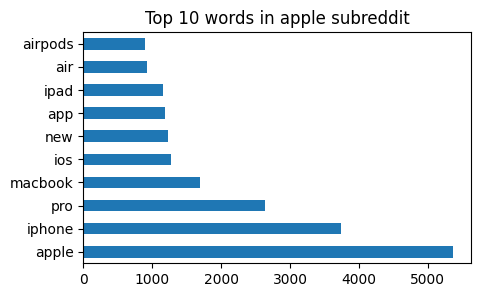

In [34]:
word_count(apple_text)

<AxesSubplot: title={'center': 'Top 10 words in google subreddit'}>

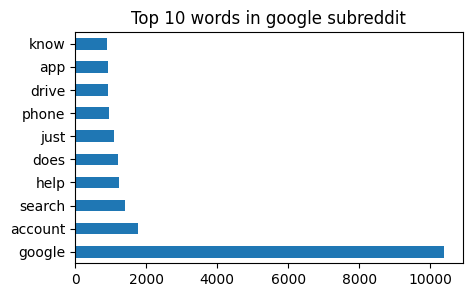

In [35]:
word_count(google_text)

**Bigram**

<AxesSubplot: title={'center': 'Top 10 words in apple subreddit'}>

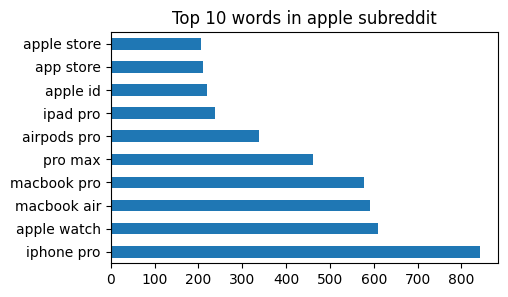

In [36]:
word_count(apple_text,ngram_range=(2,2))

<AxesSubplot: title={'center': 'Top 10 words in google subreddit'}>

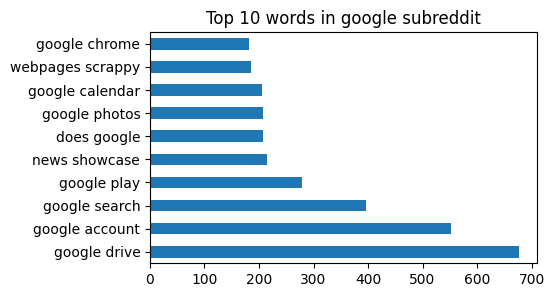

In [37]:
word_count(google_text,ngram_range=(2,2))

**Insights from word frequency analysis**
- Most frequently mentioned words in both subreddits are mostly related to their products. For Apple subreddit, users have extensive discussion on ipad, airpods, macbook, watch, iphone. For Google subreddit, discussion on products centred around chrome, calendar, photos and google drive.
- The key words 'apple' and 'google' are frequently mentioned in the subreddits. Even though these key words will improve classification accuracy, they do not help the model in capturing the specific contents that users write about the products. Therefore, these words will be removed subsequently.

## Combine DataFrames

In [38]:
# Combine apple and google data
combined_text = pd.concat([google_text,apple_text])
print(combined_text.shape)
combined_text.head()

(36057, 4)


,text,subreddit,length_of_text,word_count
0,frauenrztin mnchen zentrum schwangerenvorsorge,google,47,4
1,petition to save stadia i do not have high exp...,google,194,38
2,google stadia will be shutting down in january...,google,89,13
3,google will not let you create an email withou...,google,62,12
4,recover android backup with different resoluti...,google,56,7


## Text Preprocessing

The following text preprocessing were done to prepare text data for modelling.
- Tokenisation
- Remove stop words, including custom stop words (e.g. 'Apple' and 'Google')
- Lemmatising and stemming

#### Tokenisation

In [39]:
combined_text['tokenised'] = combined_text['text'].apply(lambda x:word_tokenize(x))
combined_text.head()

,text,subreddit,length_of_text,word_count,tokenised
0,frauenrztin mnchen zentrum schwangerenvorsorge,google,47,4,"[frauenrztin, mnchen, zentrum, schwangerenvors..."
1,petition to save stadia i do not have high exp...,google,194,38,"[petition, to, save, stadia, i, do, not, have,..."
2,google stadia will be shutting down in january...,google,89,13,"[google, stadia, will, be, shutting, down, in,..."
3,google will not let you create an email withou...,google,62,12,"[google, will, not, let, you, create, an, emai..."
4,recover android backup with different resoluti...,google,56,7,"[recover, android, backup, with, different, re..."


#### Remove stop words

- Frequently mentioned key words like 'google' and 'apple' will be set as stop words as well.

In [40]:
# Custom stopwords
stop_words = stopwords.words('english')
additional_stop_words = ['google','apple']
stop_words.extend(additional_stop_words)

In [41]:
def remove_stop_words(list_of_words):
    for word in stop_words:
        if word in list_of_words:
            list_of_words.remove(word)
    return list_of_words

In [42]:
combined_text['tokenised'] = combined_text['tokenised'].apply(remove_stop_words)
combined_text.head()

,text,subreddit,length_of_text,word_count,tokenised
0,frauenrztin mnchen zentrum schwangerenvorsorge,google,47,4,"[frauenrztin, mnchen, zentrum, schwangerenvors..."
1,petition to save stadia i do not have high exp...,google,194,38,"[petition, save, stadia, high, expectations, i..."
2,google stadia will be shutting down in january...,google,89,13,"[stadia, shutting, january, purchases, will, b..."
3,google will not let you create an email withou...,google,62,12,"[let, create, email, without, phone, number]"
4,recover android backup with different resoluti...,google,56,7,"[recover, android, backup, different, resoluti..."


#### Lemmatising and Stemming

In [43]:
# Lemmatise
lemmatizer = WordNetLemmatizer()
combined_text['lemmatised'] = combined_text['tokenised'].apply(lambda x:[lemmatizer.lemmatize(word) for word in x])

In [44]:
# Stemming
stemmer = PorterStemmer()
combined_text['stemmed'] = combined_text['tokenised'].apply(lambda x:[stemmer.stem(word) for word in x])

In [45]:
# Join the list of strings in each row
combined_text['stemmed'] = combined_text['stemmed'].apply(lambda x:' '.join(x))
combined_text['lemmatised'] = combined_text['lemmatised'].apply(lambda x:' '.join(x))
combined_text.head()

,text,subreddit,length_of_text,word_count,tokenised,lemmatised,stemmed
0,frauenrztin mnchen zentrum schwangerenvorsorge,google,47,4,"[frauenrztin, mnchen, zentrum, schwangerenvors...",frauenrztin mnchen zentrum schwangerenvorsorge,frauenrztin mnchen zentrum schwangerenvorsorg
1,petition to save stadia i do not have high exp...,google,194,38,"[petition, save, stadia, high, expectations, i...",petition save stadium high expectation i not d...,petit save stadia high expect i not delusion i...
2,google stadia will be shutting down in january...,google,89,13,"[stadia, shutting, january, purchases, will, b...",stadium shutting january purchase will be refu...,stadia shut januari purchas will be refund tec...
3,google will not let you create an email withou...,google,62,12,"[let, create, email, without, phone, number]",let create email without phone number,let creat email without phone number
4,recover android backup with different resoluti...,google,56,7,"[recover, android, backup, different, resoluti...",recover android backup different resolution pa...,recov android backup differ resolut pattern


## Export Cleaned Data

In [46]:
combined_text.drop(columns=['tokenised','length_of_text','word_count']).to_csv('Cleaned Datasets/cleaned_dataset.csv',index=False)

## Summary of Exploratory Data Analysis

- Both subreddits are not text-heavy. Many users tend to write short posts within 20 words, or even only post a short title without any body content.
- We see quite a number of spam advertisements in Google subreddit, which are not as common in Apple subreddit.
- Discussion in both subreddits are mostly centred around the respective products offered by Google/Apple. For Apple subreddit, users have extensive discussion on hardware products like ipad, airpods, macbook, watch, iphone. For Google subreddit, discussion on products centred around software products like chrome, calendar, photos and google drive.